In [45]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt


BINARY_THRESHOLD_FOR_WHITE_COLOR = 240

def thresh_frame_sobel(frame, kernel_size):
    """
    Apply Sobel edge detection to an input frame, then threshold the result
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)

    sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag) * 255)

    _, sobel_mag = cv2.threshold(sobel_mag, 50, 1, cv2.THRESH_BINARY)

    return sobel_mag.astype(bool)


def get_binary_from_equalized_grayscale(frame):
    """
    Apply histogram equalization to an input frame, threshold it and return the (binary) result.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    eq_global = cv2.equalizeHist(gray)

    _, th = cv2.threshold(eq_global, thresh=BINARY_THRESHOLD_FOR_WHITE_COLOR, maxval=255, type=cv2.THRESH_BINARY)

    return th


def binarize(img, verbose=False):
    """
    Convert an input frame to a binary image which highlight as most as possible the lane-lines.
    :param img: input color frame
    :param verbose: if True, show intermediate results
    :return: binarized frame
    """
    h, w = img.shape[:2]

    binary = np.zeros(shape=(h, w), dtype=np.uint8)

    # highlight white lines by thresholding the equalized frame
    eq_white_mask = get_binary_from_equalized_grayscale(img)
    binary = np.logical_or(binary, eq_white_mask)

    # get Sobel binary mask (thresholded gradients)
    sobel_mask = thresh_frame_sobel(img, kernel_size=5)
    binary = np.logical_or(binary, sobel_mask)

    # apply a light morphology to "fill the gaps" in the binary image
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    if verbose:
        f, ax = plt.subplots(5, 1, figsize=(20,20))
        f.set_facecolor('white')
        
        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[0].set_title('input_frame')
        ax[0].set_axis_off()
        
        ax[1].imshow(eq_white_mask, cmap='gray')
        ax[1].set_title('white mask')
        ax[1].set_axis_off()

        ax[2].imshow(sobel_mask, cmap='gray')
        ax[2].set_title('sobel mask')
        ax[2].set_axis_off()

        ax[3].imshow(binary, cmap='gray')
        ax[3].set_title('before closure')
        ax[3].set_axis_off()

        ax[4].imshow(closing, cmap='gray')
        ax[4].set_title('after closure')
        ax[4].set_axis_off()
        plt.show()

    return closing

In [49]:
img = cv2.imread('2_.png')

In [5]:
type(img)

numpy.ndarray

In [6]:
img.shape

(224, 224, 3)

In [73]:
cropped = img[110:160, :, :]

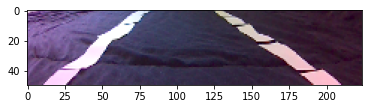

In [74]:
plt.imshow(cropped)

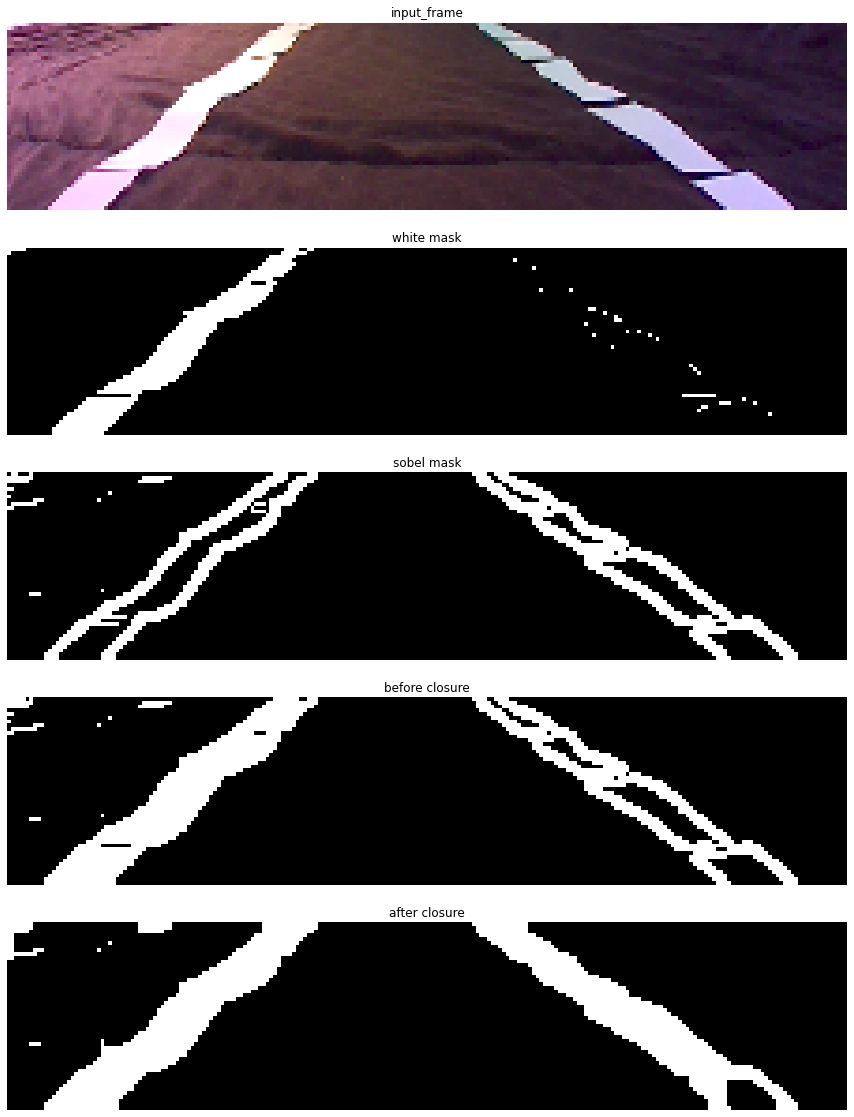

In [83]:
result= binarize(cropped, True)

In [94]:
def birdeye(img, verbose=False):
    """
    Apply perspective transform to input frame to get the bird's eye view.
    :param img: input color frame
    :param verbose: if True, show the transformation result
    :return: warped image, and both forward and backward transformation matrices
    """
    h, w = img.shape[:2]
    

    src = np.float32([[w, h],    # br
                      [0, h],    # bl
                      [70, 0],   # tl
                      [w-70, 0]])  # tr
    dst = np.float32([[w, h],       # br
                      [0, h],       # bl
                      [0, 0],       # tl
                      [w, 0]])      # tr

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)

    if verbose:
        f, axarray = plt.subplots(2, 1, figsize=(10, 10))
        f.set_facecolor('white')
        axarray[0].set_title('Before perspective transform')
        axarray[0].imshow(img, cmap='gray')
        for point in src:
            axarray[0].plot(*point, '.')
        axarray[1].set_title('After perspective transform')
        axarray[1].imshow(warped, cmap='gray')
        for point in dst:
            axarray[1].plot(*point, '.')
        for axis in axarray:
            axis.set_axis_off()
        plt.show()

    return warped, M, Minv

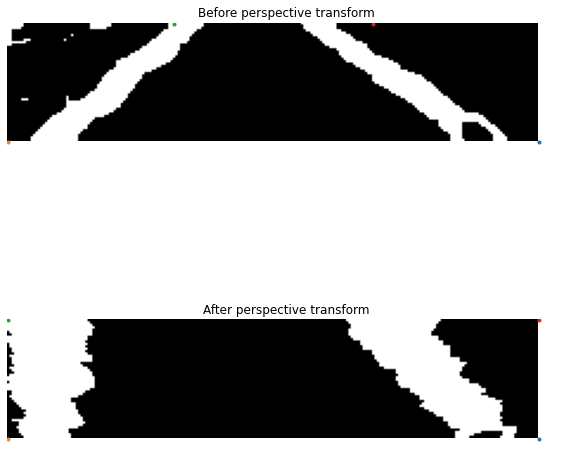

In [95]:
birdie = birdeye(result, True)

In [58]:
h, w = result.shape[:2]
print(h, w)

70 224


In [107]:
def find_base_for_lines(birdeye_binary):
    """
    Find starting points for tracking lines
    """
    height, _ = birdeye_binary.shape
    
    histogram = np.sum(birdeye_binary[height//4:-30, :], axis=0)
    
    midpoint = len(histogram) // 2    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base

def find_pixel_indices_for_lines(nonzero_x, nonzero_y, height, window_height, n_windows, leftx_base, rightx_base): 
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 100  # width of the windows +/- margin
    minpix = 30   # minimum number of pixels found to recenter window

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height - (window + 1) * window_height
        win_y_high = height - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
#         cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
#         cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low)
                          & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low)
                           & (nonzero_x < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzero_x[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return left_lane_inds, right_lane_inds

def fit_polyline_to_points(x, y):
    if not list(x) or not list(y):
        return None
    
    return np.polyfit(y, x, 2)


def get_fits_by_sliding_windows(birdeye_binary, n_windows=5, verbose=False):
    """
    Get polynomial coefficients for lane-lines detected in an binary image.
    :param birdeye_binary: input bird's eye view binary image
    :param line_lt: left lane-line previously detected
    :param line_rt: left lane-line previously detected
    :param n_windows: number of sliding windows used to search for the lines
    :param verbose: if True, display intermediate output
    :return: updated lane lines and output image
    """
    height, width = birdeye_binary.shape
    
    leftx_base, rightx_base = find_base_for_lines(birdeye_binary)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((birdeye_binary, birdeye_binary, birdeye_binary)) * 255    

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # Set height of windows
    window_height = np.int(height / n_windows)
    
    left_lane_inds, right_lane_inds = find_pixel_indices_for_lines(nonzero_x, nonzero_y, height, window_height, n_windows, leftx_base, rightx_base)

    # Extract left and right line pixel positions
    left_all_x, left_all_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    right_all_x, right_all_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    left_line = fit_polyline_to_points(left_all_x, left_all_y)
    right_line = fit_polyline_to_points(right_all_x, right_all_y)    

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_line[0] * ploty ** 2 + left_line[1] * ploty + left_line[2]
    right_fitx = right_line[0] * ploty ** 2 + right_line[1] * ploty + right_line[2]

    out_img[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    if verbose:
        f, ax = plt.subplots(2, 1, figsize=(10, 10))
        f.set_facecolor('white')
        ax[0].imshow(birdeye_binary, cmap='gray')
        ax[1].imshow(out_img)
        ax[1].plot(left_fitx, ploty, color='yellow')
        ax[1].plot(right_fitx, ploty, color='yellow')
        plt.show()

    return left_line, right_line

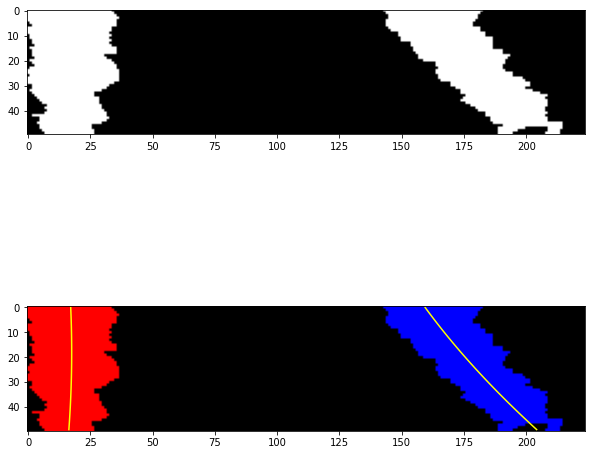

(array([-1.18147556e-03,  4.27049459e-02,  1.71216496e+01]),
 array([3.69574661e-03, 7.32062157e-01, 1.59406488e+02]))

In [108]:
birdie_bin = birdie[0]
get_fits_by_sliding_windows(birdie_bin, verbose=True)